In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
%load_ext line_profiler
%matplotlib inline

In [2]:
examples = glob.glob('examples/*.png')
examples

['examples\\0162681551.png',
 'examples\\0168366051.png',
 'examples\\0168639352.png']

In [3]:
examples = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in examples]

In [4]:
import PIL.Image
import IPython.display

def show(arr):
    IPython.display.display(PIL.Image.fromarray(arr))

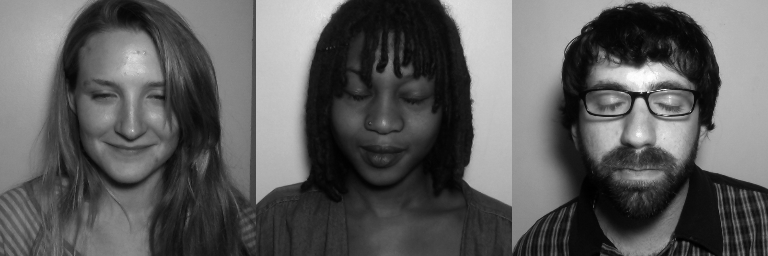

In [6]:
show(np.concatenate(examples, axis=1))

In [20]:
from ipywidgets import interact

def histogram_equalize(data, max_val=None, endpoint=False):
    input_shape = np.shape(data)
    data_flat = np.asarray(data).flatten()
    if max_val is None:
        max_val = data_flat.max()
    indices = np.argsort(data_flat)
    replacements = np.linspace(0, max_val, len(indices), endpoint=endpoint)
    data_flat[indices] = replacements
    return data_flat.reshape(*input_shape)

def _cld(gray, halfw = 8,smoothPasses = 4, sigma1 = .9, sigma2 = 3, tau = .97):
    cv2.imwrite('tmp_gray.bmp', gray)
    !wsl ./cld tmp_gray.bmp tmp_cld.bmp {halfw} {smoothPasses} {sigma1} {sigma2} {tau}
    return cv2.imread('tmp_cld.bmp', cv2.IMREAD_GRAYSCALE)

def raster_edges(gray, histogram_eq=True, cld=True, canny_low=100, canny_hi=200):
    if histogram_eq:
        gray = histogram_equalize(gray)
        
    edges = 255 - cv2.Canny(gray, canny_low, canny_hi)
    
    if cld:
        edges &= _cld(gray)

    return edges


gray = examples[0]

@interact(histogram_eq=False, cld=True, canny_low=(50, 150), canny_hi=(150, 250))
def _test(histogram_eq, cld, canny_low, canny_hi):
    edges = [raster_edges(ex, histogram_eq, cld, canny_low, canny_hi) for ex in examples]
    return show(np.concatenate(edges, axis=1))

interactive(children=(Checkbox(value=False, description='histogram_eq'), Checkbox(value=True, description='cld…

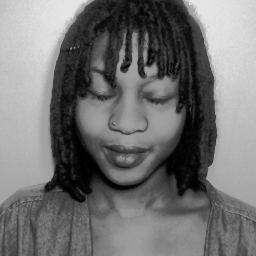

In [12]:
def to_vectors(edges):
    edges[:, 240:] = 255
    edges[:, :16] = 255
    
    cv2.imwrite("tmp.bmp", edges)
    !.\potrace-1.16.win64\potrace.exe tmp.bmp -o tmp.geojson -b geojson

    with open('tmp.geojson') as fp:
        geojson = json.load(fp)

    shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
    
    center_geom_lines = extract_centerlines(shapes)

    center_geom_lines = explode_multilines(center_geom_lines)

    center_geom_lines = [line for line in center_geom_lines 
                         if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    grad = sobel(gray)

    grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

    grad_samples = sample_grad(grad_blurred)

    tri = triangulate(grad_samples)

    graph = to_graph(tri)
